# Regression Using Variational Inference

Adapted from "Hands-on Bayesian Neural Networks - A Tutorial for Deep Learning Users" [L.V. Jospin et al, 2020]

Available at: https://arxiv.org/abs/2007.06823

Author's Github repo: https://github.com/french-paragon/BayesianMnist

In [1]:
import os # Avoids OpenMP Error
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

from torch.distributions.normal import Normal
import torch.nn.functional as F
import matplotlib.pyplot as plt

import arviz as az

import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ",device)
if device.type == "cpu":
    cuda = False
else:
    cuda = True
    

import sys
sys.path.append('../../duq/')
  
# Importing the Bayesian LR module
import pre
import post
import sgld as SG

seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

Device =  cpu
Device =  cpu


In [2]:
class VIModule(nn.Module) :
    """
    A mixin class to attach loss functions to layer. This is usefull when doing variational inference with deep learning.
    """

    def __init__(self, *args, **kwargs) :
        super().__init__(*args, **kwargs)

        self._internalLosses = []
        self.lossScaleFactor = 1

    def addLoss(self, func) :
        self._internalLosses.append(func)

    def evalLosses(self) :
        t_loss = 0

        for l in self._internalLosses :
            t_loss = t_loss + l(self)

        return t_loss

    def evalAllLosses(self) :

        t_loss = self.evalLosses()*self.lossScaleFactor
        
        for m in self.children() :
            if isinstance(m, VIModule) :
                t_loss = t_loss + m.evalAllLosses()*self.lossScaleFactor
                
        return t_loss


In [3]:
class MeanFieldGaussianFeedForward(VIModule) :
    """
    A feed forward layer with a Gaussian prior distribution and a Gaussian variational posterior.
    """

    def __init__(self, 
              in_features, 
              out_features, 
              bias = True,  
              groups=1, 
              weightPriorMean = 0, 
              weightPriorSigma = 1.,
              biasPriorMean = 0, 
              biasPriorSigma = 1.,
              initMeanZero = False,
              initBiasMeanZero = False,
              initPriorSigmaScale = 0.01) :


        super(MeanFieldGaussianFeedForward, self).__init__()

        self.samples = {'weights' : None, 'bias' : None, 'wNoiseState' : None, 'bNoiseState' : None}

        self.in_features = in_features
        self.out_features = out_features
        self.has_bias = bias

        self.weights_mean = Parameter((0. if initMeanZero else 1.)*(torch.rand(out_features, int(in_features/groups))-0.5))
        self.lweights_sigma = Parameter(torch.log(initPriorSigmaScale*weightPriorSigma*torch.ones(out_features, int(in_features/groups))))

        self.noiseSourceWeights = Normal(torch.zeros(out_features, int(in_features/groups)), 
                                   torch.ones(out_features, int(in_features/groups)))

        self.addLoss(lambda s : 0.5*s.getSampledWeights().pow(2).sum()/weightPriorSigma**2)
        self.addLoss(lambda s : -self.out_features/2*np.log(2*np.pi) - 0.5*s.samples['wNoiseState'].pow(2).sum() - s.lweights_sigma.sum())

        if self.has_bias :
            self.bias_mean = Parameter((0. if initBiasMeanZero else 1.)*(torch.rand(out_features)-0.5))
            self.lbias_sigma = Parameter(torch.log(initPriorSigmaScale*biasPriorSigma*torch.ones(out_features)))

            self.noiseSourceBias = Normal(torch.zeros(out_features), torch.ones(out_features))

            self.addLoss(lambda s : 0.5*s.getSampledBias().pow(2).sum()/biasPriorSigma**2)
            self.addLoss(lambda s : -self.out_features/2*np.log(2*np.pi) - 0.5*s.samples['bNoiseState'].pow(2).sum() - self.lbias_sigma.sum())


    def sampleTransform(self, stochastic=True) :
        self.samples['wNoiseState'] = self.noiseSourceWeights.sample().to(device=self.weights_mean.device)
        self.samples['weights'] = self.weights_mean + (torch.exp(self.lweights_sigma)*self.samples['wNoiseState'] if stochastic else 0)

        if self.has_bias :
            self.samples['bNoiseState'] = self.noiseSourceBias.sample().to(device=self.bias_mean.device)
            self.samples['bias'] = self.bias_mean + (torch.exp(self.lbias_sigma)*self.samples['bNoiseState'] if stochastic else 0)

    def getSampledWeights(self) :
        return self.samples['weights']

    def getSampledBias(self) :
        return self.samples['bias']

    def forward(self, x, stochastic=True) :

        self.sampleTransform(stochastic=stochastic)

        return nn.functional.linear(x, self.samples['weights'], bias = self.samples['bias'] if self.has_bias else None)

In [4]:
class VI(VIModule):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 num_units,
                 linearWPriorSigma = 1., 
                 linearBPriorSigma = 5., 
                 p_mc_dropout = 0.5) :

        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_units = num_units
        self.p_mc_dropout = p_mc_dropout

    
        self.linear1 = MeanFieldGaussianFeedForward(input_dim, num_units,
                                                    weightPriorSigma = linearWPriorSigma, 
                                                    biasPriorSigma = linearBPriorSigma,
                                                    initPriorSigmaScale=1e-7)
        self.linear2 = MeanFieldGaussianFeedForward(num_units, num_units,
                                                    weightPriorSigma = linearWPriorSigma, 
                                                    biasPriorSigma = linearBPriorSigma,
                                                    initPriorSigmaScale=1e-7)
        self.linear3 = MeanFieldGaussianFeedForward(num_units, output_dim,
                                                    weightPriorSigma = linearWPriorSigma, 
                                                    biasPriorSigma = linearBPriorSigma,
                                                    initPriorSigmaScale=1e-7)

        self.activation = nn.ReLU(inplace = True)
        
    def forward(self, x, stochastic=True):

        x = x.view(-1, self.input_dim)
        x = self.linear1(x, stochastic=stochastic)
        x = self.activation(x)
        if self.p_mc_dropout is not None: x = F.dropout(x, p=self.p_mc_dropout, training=True)
        x = self.linear2(x, stochastic=stochastic)
        x = self.activation(x)
        if self.p_mc_dropout is not None: x = F.dropout(x, p=self.p_mc_dropout, training=True)
        x = self.linear3(x, stochastic=stochastic)
        
        return x

In [5]:
def f(x):
    """ Function to plot a damped sinusoid """ 
    A = 2         # Initial amplitude
    lamb = 0.2    # Decay constant
    w = 2         # Angular frequency
    phi = 0       # Phase angle at t=0
    flipped = False # Whether to flip the x axis or not
    if torch.is_tensor(x):
        res = A*torch.exp(-lamb*x)*(torch.cos(w*x+phi) + torch.sin(w*x + phi))
        if flipped:
            res = res.numpy()
            res = np.flip(res).copy()
            res = torch.Tensor(res)
        return res
    else:
        res = A*np.exp(-lamb*x)*(np.cos(w*x+phi) + np.sin(w*x + phi))
        if flipped: res = np.flip(res)
        return res

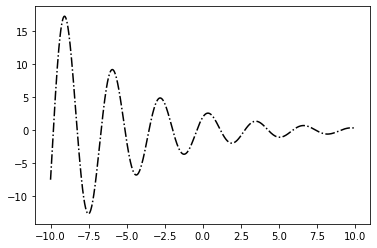

In [6]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-10,10,1000)
Y = f(X)

plt.plot(X,Y,'k-.')

df = pd.DataFrame({"X":X,"Y":Y})

x_cols=[0]
y_cols=[1]
component = 0 # Sort by the x component 
cutoff_percentile = (0.5,0.5)
val_split = 0.2
component_name = "Y"

df, data_mean, data_std = pre.process_df_euclid(df=df, x_cols=x_cols)

y_mean = data_mean[y_cols].values
x_mean = data_mean[x_cols].values
y_std = data_std[y_cols].values
x_std = data_std[x_cols].values

TRAIN, VAL, TEST = pre.split_data(df, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

In [7]:
# Parameters of simulation
num_epochs = 1500 
batch_size = 50 #len(x_train)
test_batch_size = 100
num_networks = 5
lr = 1e-3
p_mc_dropout = None
num_units = 300
num_tests = num_networks*5

In [8]:
import time

start = time.time()

# Train data
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
N = len(train_data)
batchLen = len(train_loader)
digitsBatchLen = len(str(batchLen))

# Test data
test_data = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, num_workers=0)


# Array of networks (for ensemble)
nets = []

for i in range(num_networks):
    print("Training model {}/{}:".format(i+1, num_networks))
    net = VI(input_dim=1,
           output_dim=1,
           num_units=num_units,
           p_mc_dropout=p_mc_dropout)    #p_mc_dropout=None will disable MC-Dropout for this bnn, as we found out it makes learning much much slower.

    loss = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    optimizer.zero_grad()
    
    for n in np.arange(num_epochs) :

        for batch_id, sampl in enumerate(train_loader) :
            x, y = sampl
            pred = net(x, stochastic=True)
            logprob = loss(pred, y)
            l = N*logprob
            modelloss = net.evalAllLosses()
            l += modelloss
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            print(
                f"\tEpoch {n+1}/{num_epochs}"
                f" Train step {batch_id+1}/{batchLen}"
                f" Prob = {torch.exp(-logprob.detach().cpu()).item():4f}"
                f" Model = {modelloss.detach().cpu().item():.1f}"
                f" Loss = {l.detach().cpu().item():.1f}",
                end='\r')                                                                
    print("")

    nets.append(net)
    
    
end = time.time()
print(f"Time taken: {end-start}")

Training model 1/5:
	Epoch 1500/1500 Train step 4/4 Prob = 0.993282 Model = 874946.9 Loss = 874948.2.6
Training model 2/5:
	Epoch 1500/1500 Train step 4/4 Prob = 0.993096 Model = 874902.1 Loss = 874903.4.6
Training model 3/5:
	Epoch 1500/1500 Train step 4/4 Prob = 0.992691 Model = 874909.9 Loss = 874911.4.4
Training model 4/5:
	Epoch 1500/1500 Train step 4/4 Prob = 0.994687 Model = 874740.2 Loss = 874741.2.5
Training model 5/5:
	Epoch 1500/1500 Train step 4/4 Prob = 0.995251 Model = 875051.1 Loss = 875052.1.4
Time taken: 423.42793583869934


In [9]:
#x_test, y_test = next(iter(test_loader))
def generate_samples(X, y_mean, y_std, num_tests):
    samples = []
    for i in range(num_tests):
        print("\r", "\tTest run {}/{}".format(i+1, num_tests), end="")
        net = np.random.randint(num_networks)
        net = nets[net]
        preds = net.cpu().forward(X).data.numpy()
        samples.append(preds)

    samples = np.array(samples)
    samples = pre.unnormalise(samples, y_mean, y_std)

    means = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)
    stds = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)

    for i in range(samples.shape[2]):   # Looping over each dependent var
        for j in range(samples.shape[1]): # Looping over each datapoint
            means[i, j] = samples[:, j, i].mean()
            stds[i, j] = samples[:, j, i].std()
    
    samples = np.moveaxis(samples, 2, 0)
    return samples, means, stds

def run_sampling(X, Y, num_tests):
    samples, means, stds= generate_samples(X, y_mean, y_std, num_tests) 

    samples = np.squeeze(samples)

    Y_np = pre.unnormalise(Y.squeeze().numpy(), y_mean, y_std)
    return samples, means, stds, Y_np


samples_full, means_full, stds_full, y_train_np_full = run_sampling(torch.Tensor(df["X"]), torch.Tensor(df["Y"]), num_tests)
means_full_, stds_full_, x_full_ = post.sort_data([means_full.squeeze(), stds_full.squeeze(), df["X"]], sortby=2)

 	Test run 25/25

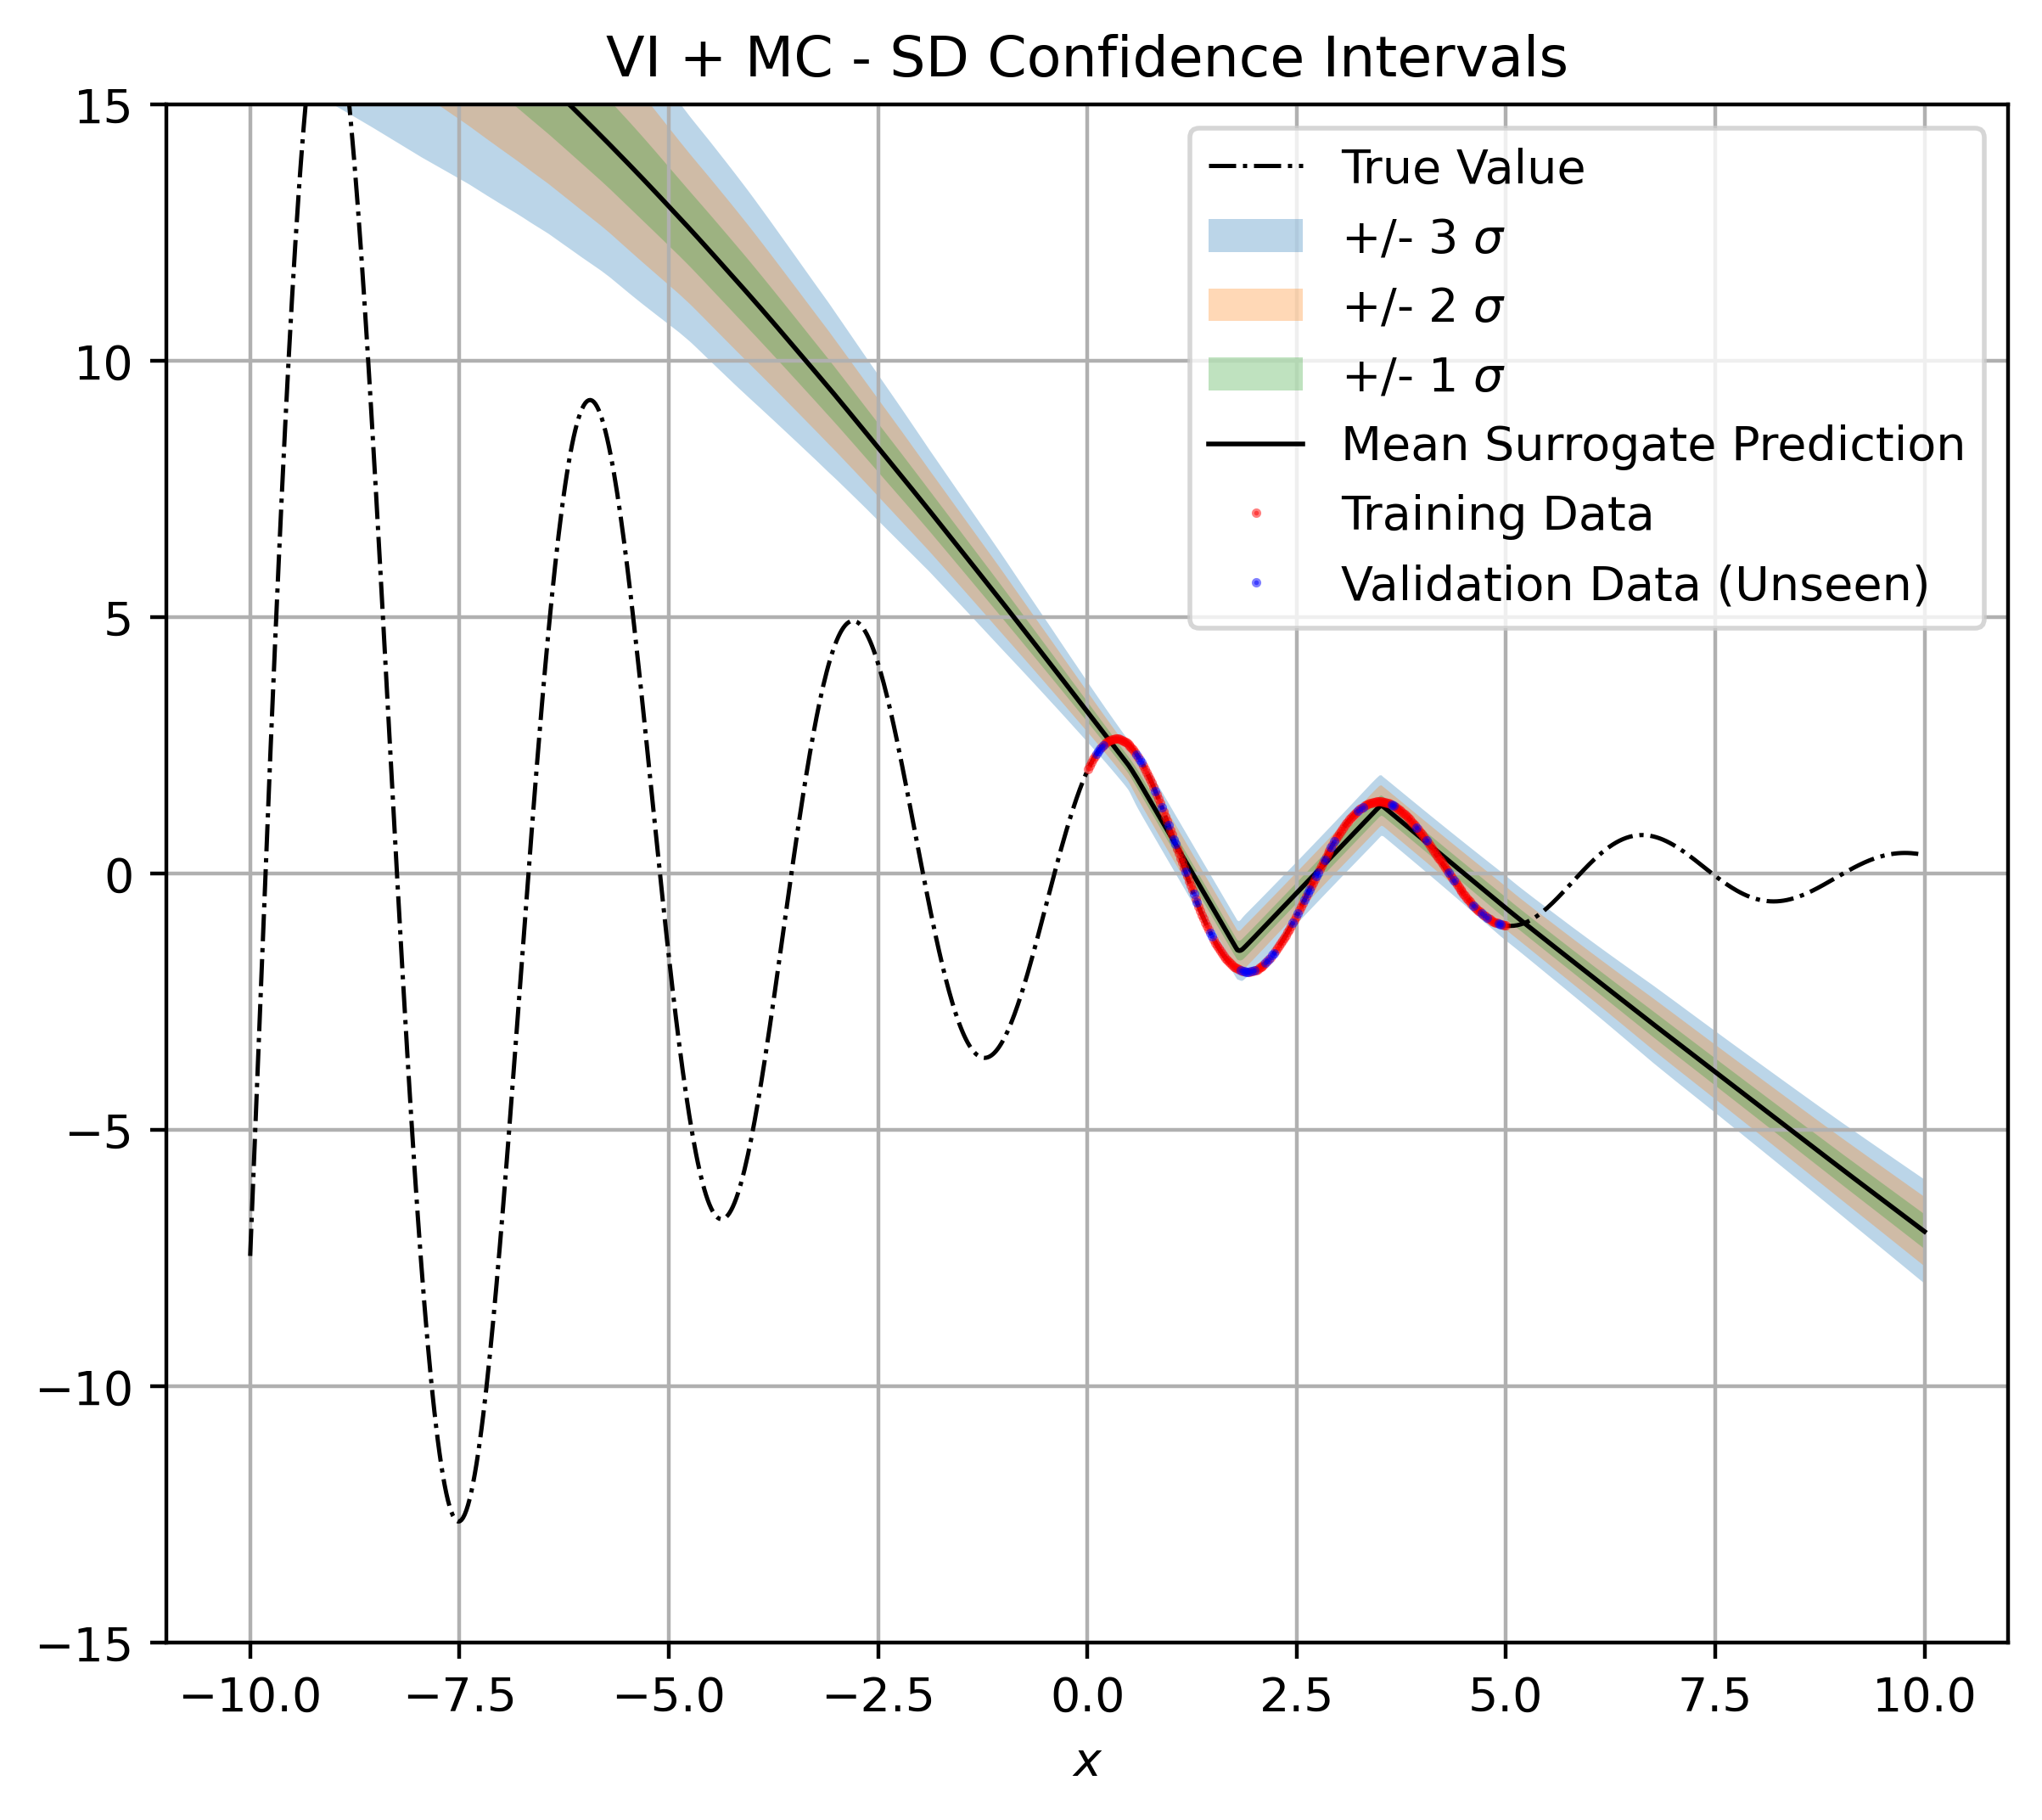

In [30]:

plt.figure(figsize=(7,6), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('VI + MC - SD Confidence Intervals')
plt.show()

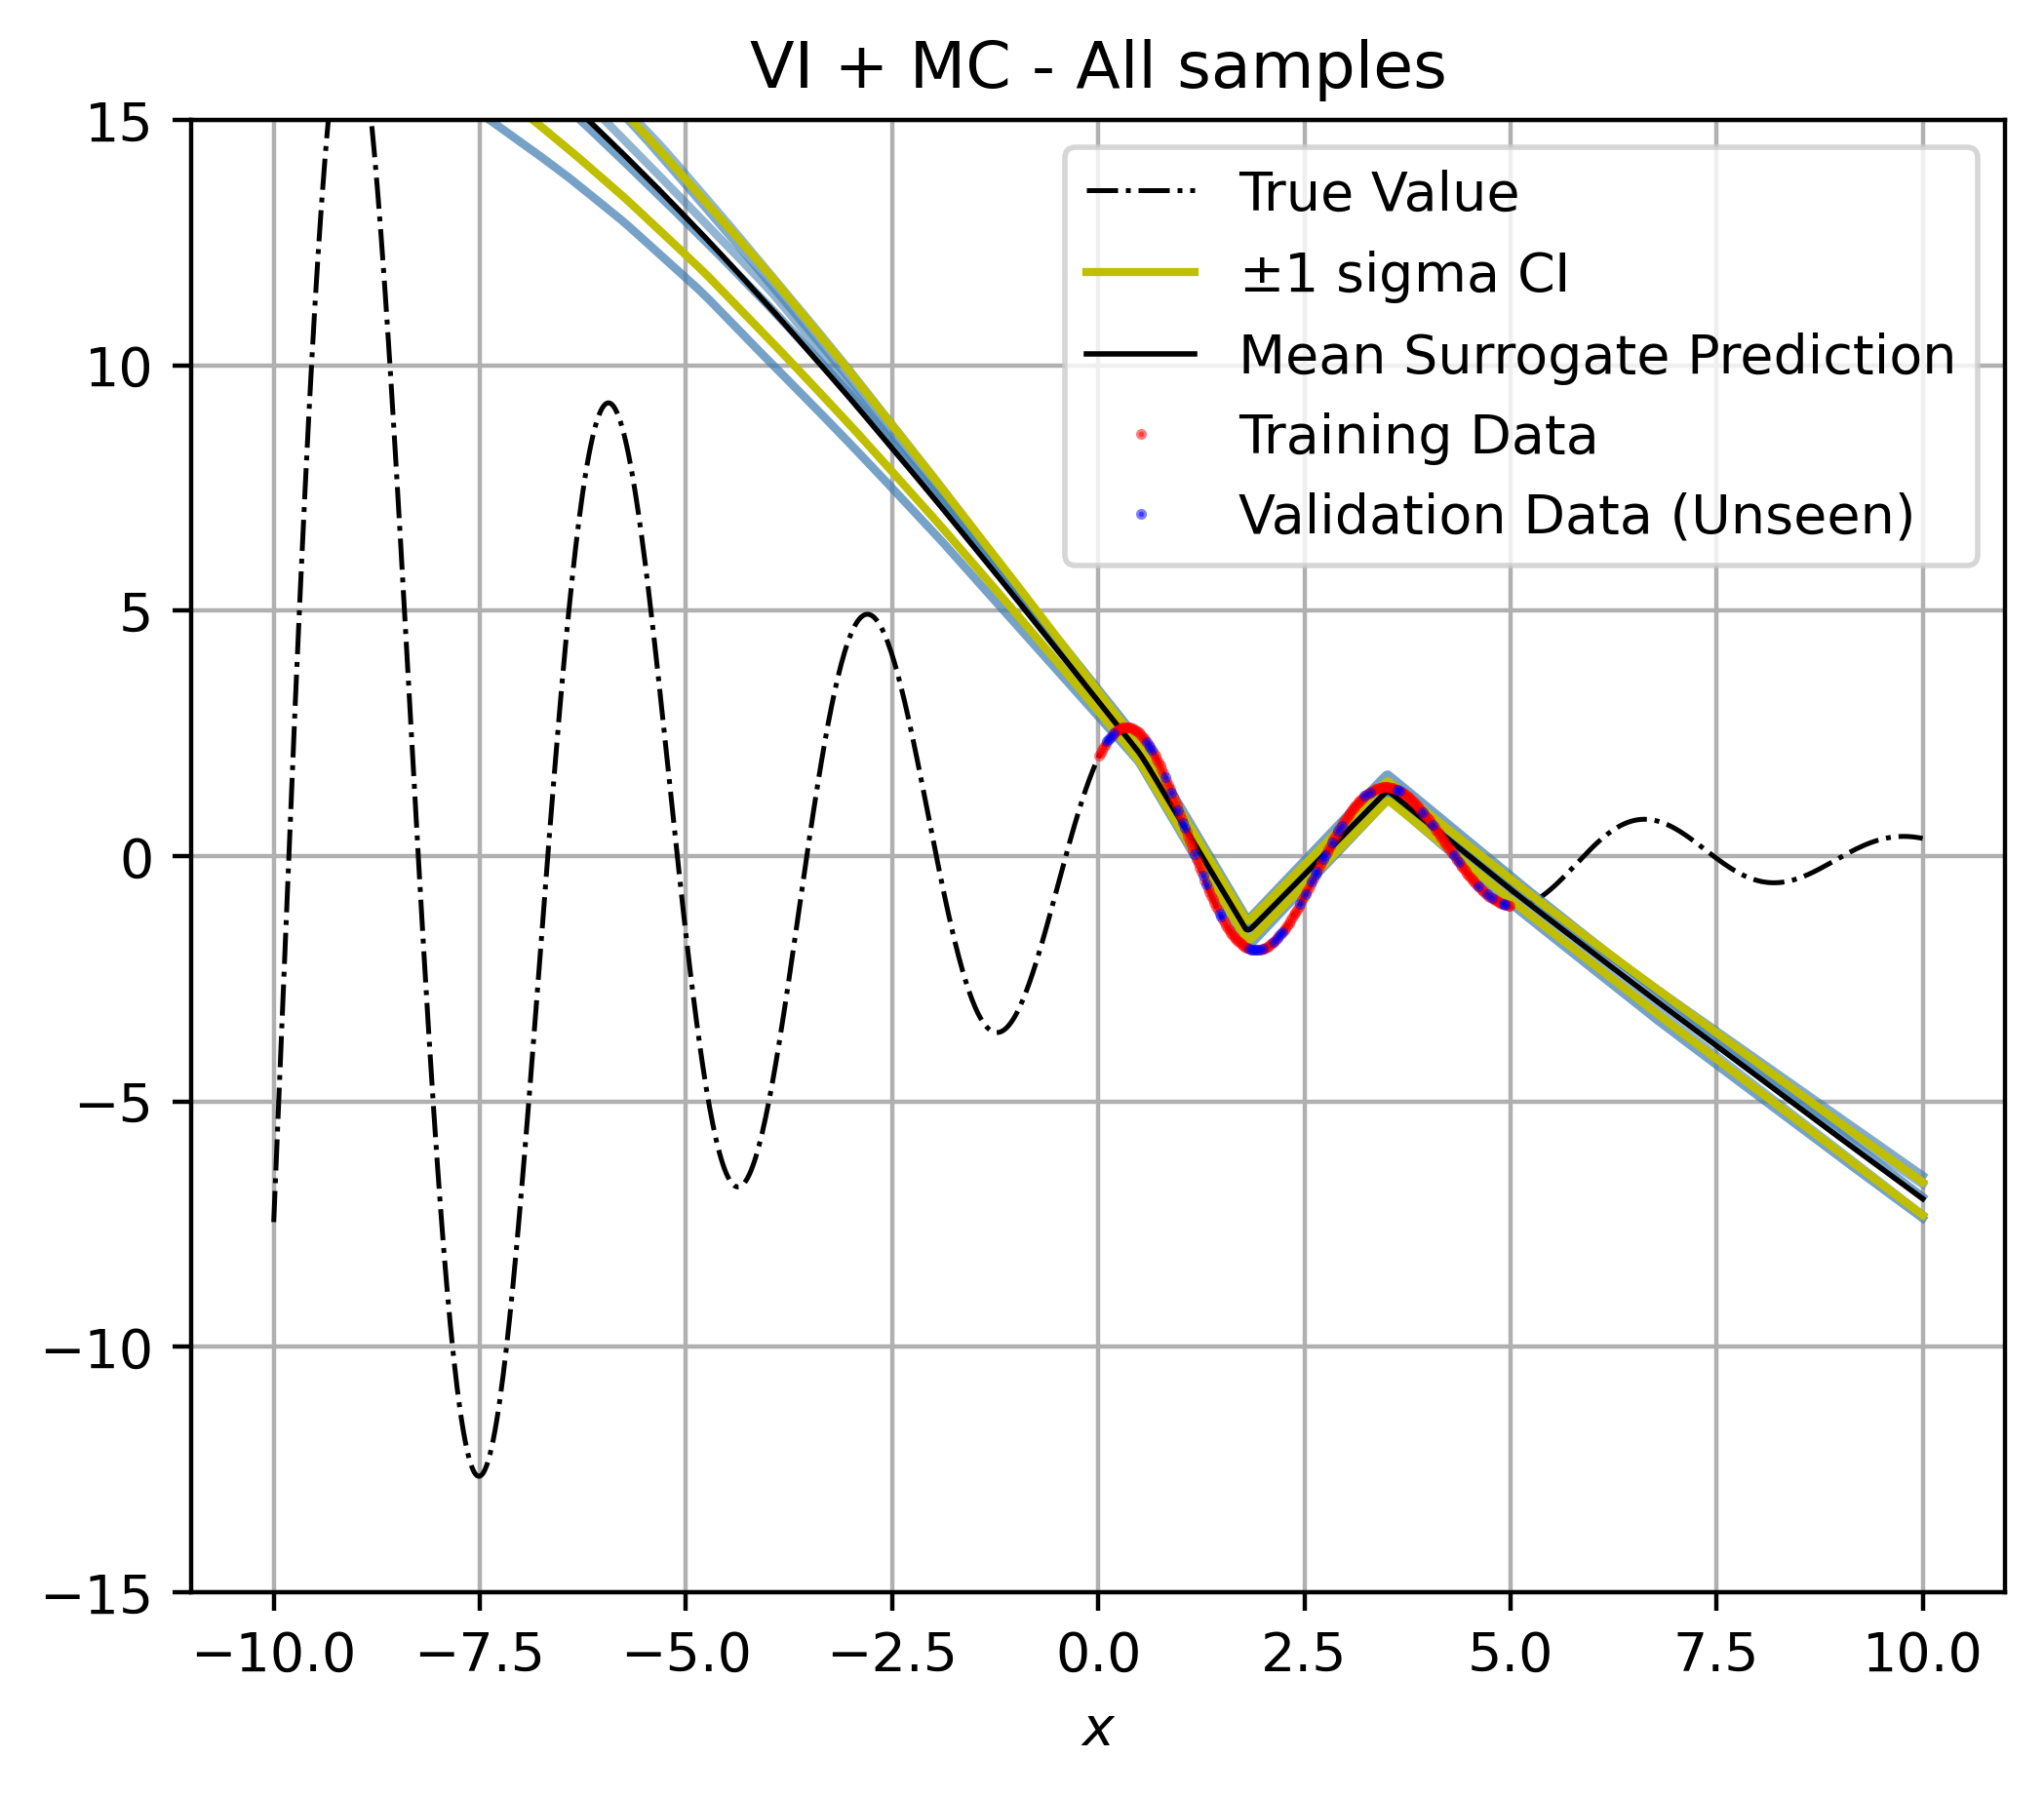

In [29]:
plt.figure(figsize=(6,5), dpi=400)
plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.plot(X, samples_full[:].T,'steelblue',alpha=0.2)
plt.plot(X, means_full_.ravel() + 1*stds_full_.flatten(),'y',label="$\pm$1 sigma CI")
plt.plot(X, means_full_.ravel() - 1*stds_full_.flatten(),'y')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('VI + MC - All samples')
plt.show()